[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ourownstory/neural_prophet/blob/master/tutorials/feature-use/benchmarking.ipynb)

# Running benchmarking experiments
Note: The Benchmarking Framework does currently not properly support auto-regression or lagged covariates with multiple step ahead forecasts.

In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install git+https://github.com/ourownstory/neural_prophet.git # may take a while
    #!pip install neuralprophet # much faster, but may not have the latest upgrades/bugfixes
    
import pandas as pd
from neuralprophet import NeuralProphet, set_log_level
from neuralprophet.benchmark import Dataset, NeuralProphetModel, ProphetModel
from neuralprophet.benchmark import SimpleBenchmark, CrossValidationBenchmark
set_log_level("ERROR")

WARNING - (NP.benchmark.<module>) - Benchmarking Framework is not covered by tests. Please report any bugs you find.


## Load data

In [2]:
data_location = "https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/"

air_passengers_df = pd.read_csv(data_location + 'air_passengers.csv')
peyton_manning_df = pd.read_csv(data_location + 'wp_log_peyton_manning.csv')
# retail_sales_df = pd.read_csv(data_location + 'retail_sales.csv')
# yosemite_temps_df = pd.read_csv(data_location +  'yosemite_temps.csv')
# ercot_load_df = pd.read_csv(data_location +  'ERCOT_load_2004_2021Sept.csv')[['ds', 'y']]

## 0. Configure Datasets and Model Parameters
First, we define the datasets that we would like to benchmerk on.
Next, we define the models that we want to evaluate and set their hyperparameters.

In [3]:
dataset_list = [
    Dataset(df = air_passengers_df, name = "air_passengers", freq = "MS"),
    # Dataset(df = peyton_manning_df, name = "peyton_manning", freq = "D"),
    # Dataset(df = retail_sales_df, name = "retail_sales", freq = "D"),
    # Dataset(df = yosemite_temps_df, name = "yosemite_temps", freq = "5min"),
    # Dataset(df = ercot_load_df, name = "ercot_load", freq = "H"),
]
model_classes_and_params = [
    (NeuralProphetModel, {"seasonality_mode": "multiplicative", "learning_rate": 0.1}),
    (ProphetModel, {"seasonality_mode": "multiplicative"})
]

Note: As all the classes used in the Benchmark framework are dataclasses, 
they have a print function, allowing us to peek into them if we like:

In [4]:
model_classes_and_params

[(neuralprophet.benchmark.NeuralProphetModel,
  {'seasonality_mode': 'multiplicative', 'learning_rate': 0.1}),
 (neuralprophet.benchmark.ProphetModel,
  {'seasonality_mode': 'multiplicative'})]

## 1. SimpleBenchmark
Setting up a series of Train Test Experiments is quick:

In [5]:
benchmark = SimpleBenchmark(
    model_classes_and_params=model_classes_and_params, # iterate over this list of tuples
    datasets=dataset_list, # iterate over this list
    metrics=["MAE", "MSE", "MASE", "RMSE"],
    test_percentage=25,
)
results_train, results_test = benchmark.run()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.35721
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       382.841    0.00264778       134.153           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       385.044   2.94403e-05       62.8059      0.4205      0.4205      254   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     207       385.061   0.000138238       75.3017   1.478e-06       0.001      298  LS failed, Hessian reset 
     299       385.275   3.73305e-06       72.2472      0.2634           1      405   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     336       385.284   1.70202e-05       68.2304   2.516e-07       0.001      496  LS failed, Hessian reset 
     392       385.288    9.1902e-08       72.8893      0.5977      0.5977      565   
Optimization terminat

In [6]:
results_test

,data,model,params,MAE,MSE,MASE,RMSE
0,air_passengers,NeuralProphet,"{'seasonality_mode': 'multiplicative', 'learni...",24.399951,820.348513,0.561841,28.641727
1,air_passengers,Prophet,{'seasonality_mode': 'multiplicative'},29.339378,1111.231719,0.675578,33.335142


## 2. CrossValidationBenchmark
Setting up a series of crossvalidated experiments is just as simple:

In [7]:
benchmark_cv = CrossValidationBenchmark(
    model_classes_and_params=model_classes_and_params, # iterate over this list of tuples
    datasets=dataset_list, # iterate over this list
    metrics=["MASE", "RMSE"],
    test_percentage=10,
    num_folds=3,
    fold_overlap_pct=0,
)
results_summary, results_train, results_test = benchmark_cv.run()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.98895
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       351.366    0.00298586       127.989       0.796       0.796      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       352.627   0.000181095       103.239   9.992e-07       0.001      206  LS failed, Hessian reset 
     199       352.781   6.52139e-05       74.5263      0.5281      0.5281      281   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     222       353.103   0.000400479       125.639    4.97e-06       0.001      348  LS failed, Hessian reset 
     299       353.245   4.74962e-07       77.4296           1           1      452   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     314       353.245   7.98052e-09       83.0488      0.6083      0.6083      473   
Optimization terminat

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.51834
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       393.389     0.0010801       111.202      0.1105      0.1105      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       395.369   0.000225263       54.0013      0.9473      0.9473      258   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       395.988   0.000390218       78.7515      0.3301           1      381   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     315       396.128   0.000167897       120.269   1.444e-06       0.001      442  LS failed, Hessian reset 
     399        396.22   1.20624e-06       59.8164      0.6425      0.6425      551   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     465       396.223   2.66685e-08    

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.39409
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        448.75    0.00872909       155.909      0.4404           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151       449.247   0.000602557       259.199   4.348e-06       0.001      228  LS failed, Hessian reset 
     199       449.374   1.31675e-05       57.0341           1           1      286   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     235       449.383   4.34483e-05       69.5055   5.465e-07       0.001      372  LS failed, Hessian reset 
     299       449.412   7.64522e-07       66.8116       0.358       0.358      461   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     349       449.416   6.74279e-06       66.6008    9.12e-08       0.001      563  LS failed, Hessian rese

We now also get a summary DataFrame showing the metrics' mean and standard deviation over all folds.

In [8]:
results_summary

,data,model,params,MASE,RMSE,MASE_std,RMSE_std,split
0,air_passengers,NeuralProphet,"{'seasonality_mode': 'multiplicative', 'learni...",0.280155,7.736650,0.011952,0.698001,train
1,air_passengers,Prophet,{'seasonality_mode': 'multiplicative'},0.311655,8.626823,0.020119,1.238508,train
0,air_passengers,NeuralProphet,"{'seasonality_mode': 'multiplicative', 'learni...",0.482176,22.399358,0.134568,5.635830,test
1,air_passengers,Prophet,{'seasonality_mode': 'multiplicative'},0.475724,22.638791,0.108809,4.171467,test


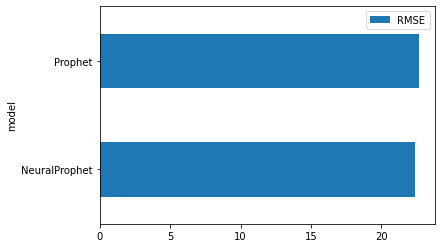

In [9]:
air_passengers = results_summary[results_summary['data'] == 'air_passengers']
air_passengers = air_passengers[air_passengers['split'] == 'test']
plt = air_passengers.plot(x='model', y='RMSE', kind='barh')

The metrics for each fold are also recoreded individually:

In [10]:
results_test

,data,model,params,MASE,RMSE
0,air_passengers,NeuralProphet,"{'seasonality_mode': 'multiplicative', 'learni...","[0.5024300821337, 0.3081724262239018, 0.635924...","[21.004299022486276, 16.300988563240793, 29.89..."
1,air_passengers,Prophet,{'seasonality_mode': 'multiplicative'},"[0.5848541887880854, 0.3272066846485105, 0.515...","[24.447931056894184, 16.871406406818302, 26.59..."


## 3. Manual Benchmark
If you need more control over the individual Experiments, you can set them up manually:

In [11]:
from neuralprophet.benchmark import SimpleExperiment, CrossValidationExperiment
from neuralprophet.benchmark import ManualBenchmark, ManualCVBenchmark

### 3.1 ManualBenchmark: Manual SimpleExperiment Benchmark

In [12]:
air_passengers_df = pd.read_csv(data_location + 'air_passengers.csv')
peyton_manning_df = pd.read_csv(data_location + 'wp_log_peyton_manning.csv')
metrics = ["MAE", "MSE", "RMSE", "MASE", "MSSE", "MAPE", "SMAPE"]
experiments = [
    SimpleExperiment(
        model_class=NeuralProphetModel,
        params={"seasonality_mode": "multiplicative", "learning_rate": 0.1},
        data=Dataset(df=air_passengers_df, name="air_passengers", freq="MS"),
        metrics=metrics,
        test_percentage=25,
    ),
    SimpleExperiment(
        model_class=ProphetModel,
        params={"seasonality_mode": "multiplicative", },
        data=Dataset(df=air_passengers_df, name="air_passengers", freq="MS"),
        metrics=metrics,
        test_percentage=25,
    ),
    SimpleExperiment(
        model_class=NeuralProphetModel,
        params={"learning_rate": 0.1},
        data=Dataset(df=peyton_manning_df, name="peyton_manning", freq="D"),
        metrics=metrics,
        test_percentage=15,
    ),
    SimpleExperiment(
        model_class=ProphetModel,
        params={},
        data=Dataset(df=peyton_manning_df, name="peyton_manning", freq="D"),
        metrics=metrics,
        test_percentage=15,
    ),
]
benchmark = ManualBenchmark(
    experiments=experiments,
    metrics=metrics,
)
results_train, results_test = benchmark.run()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.35721
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       382.841    0.00264778       134.153           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       385.044   2.94403e-05       62.8059      0.4205      0.4205      254   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     207       385.061   0.000138238       75.3017   1.478e-06       0.001      298  LS failed, Hessian reset 
     299       385.275   3.73305e-06       72.2472      0.2634           1      405   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     336       385.284   1.70202e-05       68.2304   2.516e-07       0.001      496  LS failed, Hessian reset 
     392       385.288    9.1902e-08       72.8893      0.5977      0.5977      565   
Optimization terminat

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -13.5996
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6769.19    0.00208086       212.766           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6781.78     0.0145362       194.891           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6787.82    0.00219454       253.652      0.7268      0.7268      364   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     312        6788.4   7.71754e-05       186.832   2.494e-07       0.001      416  LS failed, Hessian reset 
     399       6789.84    0.00161157       183.593           1           1      516   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     420          6791   0.000321857    

In [13]:
results_test

,data,model,params,MAE,MSE,RMSE,MASE,MSSE,MAPE,SMAPE
0,air_passengers,NeuralProphet,"{'seasonality_mode': 'multiplicative', 'learni...",24.173867,810.089487,28.462071,0.556635,0.311347,5.805671,2.792496
1,air_passengers,Prophet,{'seasonality_mode': 'multiplicative'},29.339378,1111.231719,33.335142,0.675578,0.427087,7.358026,3.505944
2,peyton_manning,NeuralProphet,{'learning_rate': 0.1},0.553390,0.420536,0.648487,1.567959,1.579489,7.121852,3.427362
3,peyton_manning,Prophet,{},0.601819,0.472787,0.687595,1.705178,1.775741,7.772078,3.727366


### 3.2 ManualCVBenchmark: Manual CrossValidationExperiment Benchmark

In [14]:
air_passengers_df = pd.read_csv(data_location + 'air_passengers.csv')
experiments = [
    CrossValidationExperiment(
        model_class=NeuralProphetModel,
        params={"seasonality_mode": "multiplicative", "learning_rate": 0.1},
        data=Dataset(df=air_passengers_df, name="air_passengers", freq="MS"),
        metrics=metrics,
        test_percentage=10,
        num_folds=3,
        fold_overlap_pct=0,
    ),
    CrossValidationExperiment(
        model_class=ProphetModel,
        params={"seasonality_mode": "multiplicative", },
        data=Dataset(df=air_passengers_df, name="air_passengers", freq="MS"),
        metrics=metrics,
        test_percentage=10,
        num_folds=3,
        fold_overlap_pct=0,
    ),
]
benchmark_cv = ManualCVBenchmark(
    experiments=experiments,
    metrics=metrics,
)
results_summary, results_train, results_test = benchmark_cv.run()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.98895
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       351.366    0.00298586       127.989       0.796       0.796      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       352.627   0.000181095       103.239   9.992e-07       0.001      206  LS failed, Hessian reset 
     199       352.781   6.52139e-05       74.5263      0.5281      0.5281      281   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     222       353.103   0.000400479       125.639    4.97e-06       0.001      348  LS failed, Hessian reset 
     299       353.245   4.74962e-07       77.4296           1           1      452   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     314       353.245   7.98052e-09       83.0488      0.6083      0.6083      473   
Optimization terminat

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.51834
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       393.389     0.0010801       111.202      0.1105      0.1105      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       395.369   0.000225263       54.0013      0.9473      0.9473      258   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       395.988   0.000390218       78.7515      0.3301           1      381   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     315       396.128   0.000167897       120.269   1.444e-06       0.001      442  LS failed, Hessian reset 
     399        396.22   1.20624e-06       59.8164      0.6425      0.6425      551   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     465       396.223   2.66685e-08    

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.39409
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        448.75    0.00872909       155.909      0.4404           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151       449.247   0.000602557       259.199   4.348e-06       0.001      228  LS failed, Hessian reset 
     199       449.374   1.31675e-05       57.0341           1           1      286   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     235       449.383   4.34483e-05       69.5055   5.465e-07       0.001      372  LS failed, Hessian reset 
     299       449.412   7.64522e-07       66.8116       0.358       0.358      461   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     349       449.416   6.74279e-06       66.6008    9.12e-08       0.001      563  LS failed, Hessian rese

In [15]:
results_summary

,data,model,params,MAE,MSE,RMSE,MASE,MSSE,MAPE,SMAPE,MAE_std,MSE_std,RMSE_std,MASE_std,MSSE_std,MAPE_std,SMAPE_std,split
0,air_passengers,NeuralProphet,"{'seasonality_mode': 'multiplicative', 'learni...",6.132243,65.202424,8.029516,0.287259,0.085798,3.159643,1.566218,0.657536,13.675259,0.853989,0.008197,0.003429,0.155083,0.077228,train
1,air_passengers,Prophet,{'seasonality_mode': 'multiplicative'},6.671154,75.955971,8.626823,0.311655,0.098918,3.098723,1.557932,0.936781,20.578062,1.238508,0.020119,0.013879,0.248192,0.125825,train
0,air_passengers,NeuralProphet,"{'seasonality_mode': 'multiplicative', 'learni...",19.599296,534.356876,22.473807,0.483722,0.234689,4.645664,2.349843,6.625242,255.376633,5.411551,0.133058,0.087635,1.383850,0.733479,test
1,air_passengers,Prophet,{'seasonality_mode': 'multiplicative'},18.901066,529.915994,22.638791,0.475724,0.246100,4.566266,2.253674,3.850787,179.122320,4.171467,0.108809,0.101487,0.707946,0.352328,test
